---
<h1><B> Fraud Analytics (CS6890)  </h1></B></center>

---

<table>
<tr> 
<td><h3> Assignment: </td>
<td><h3> 4 </td>
</tr>
<tr> 
<td><h3> Title : </td>
<td><h3> Fraud Detection Using an Autoencoder and Variational Autoencoder </td>
</tr>
<tr> 
<td><h3> Team Details : </td>
<td>

<table>
<tr>
<th> <h3> Name </th>
<th> <h3> Roll Number </th>
</tr>



<tr> 
<td><h5> Shreesh Gupta </td>
<td><h5> CS23MTECH12009 </td>
</tr>
<tr> 
<td><h5> Hrishikesh Hemke </td>
<td><h5> CS23MTECH14003 </td>
</tr>
<tr> 
<td><h5> Manan Patel </td>
<td><h5> CS23MTECH14006 </td>
</tr>
<tr> 
<td><h5> Yug Patel </td>
<td><h5> CS23MTECH14019 </td>
</tr>
<tr> 
<td><h5> Bhargav Patel </td>
<td><h5> CS23MTECH11026 </td>
</tr>

<table>



</td>
</tr>
<table>


In [4]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, auc                   
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from tensorflow.keras import models,layers
from tensorflow.keras.models import Model
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import (roc_curve,auc)
from sklearn.manifold import TSNE

In [5]:
# Load the dataset
data = pd.read_csv('creditcard.csv')

# Display the first few rows of the dataset for a quick overview
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# Data Exploration

Here we are plotting a count plot to visualize the distribution of fraud vs. non-fraud transactions in a dataset.

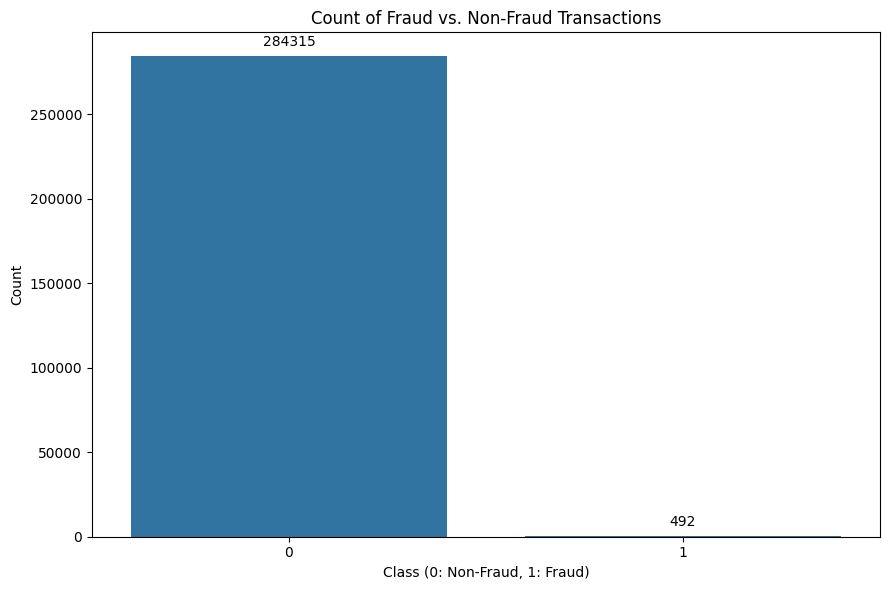

In [6]:
# Create the count plot
fig, ax = plt.subplots(figsize=(9, 6))
sns.countplot(x='Class', data=data, ax=ax)

# Set the title, x-label, and y-label
ax.set_title('Count of Fraud vs. Non-Fraud Transactions')
ax.set_xlabel('Class (0: Non-Fraud, 1: Fraud)')
ax.set_ylabel('Count')

# Add count labels above the bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                 (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha = 'center', va = 'center', 
                 xytext = (0, 10), 
                 textcoords = 'offset points')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

Here we are plotting histogram that visually compares the distribution of transaction amounts for normal and fraud transaction.
Here we can detect differences bwtteen the two classes

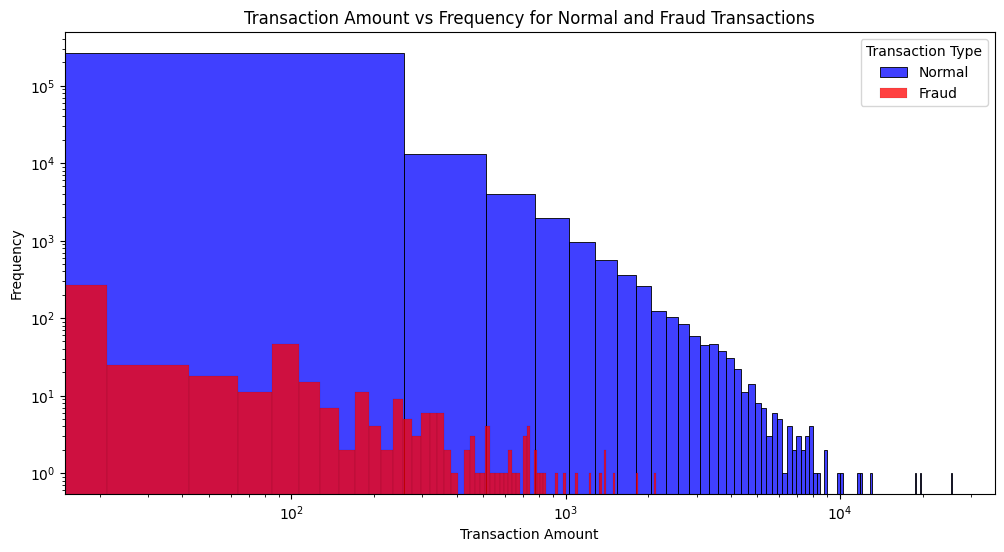

In [7]:
# Create a figure for plotting
plt.figure(figsize=(12, 6))

# Plotting transaction amount vs frequency for normal transactions
sns.histplot(data[data['Class'] == 0]['Amount'], bins=100, color='blue', label='Normal', kde=False)
sns.histplot(data[data['Class'] == 1]['Amount'], bins=100, color='red', label='Fraud', kde=False)

plt.title('Transaction Amount vs Frequency for Normal and Fraud Transactions')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.legend(title='Transaction Type')
plt.xscale('log')  # Using log scale for better visualization of the spread
plt.yscale('log')  # Log scale for frequency to handle wide range of values
plt.show()

In our approach we are converting time into hours and min to do feature selection

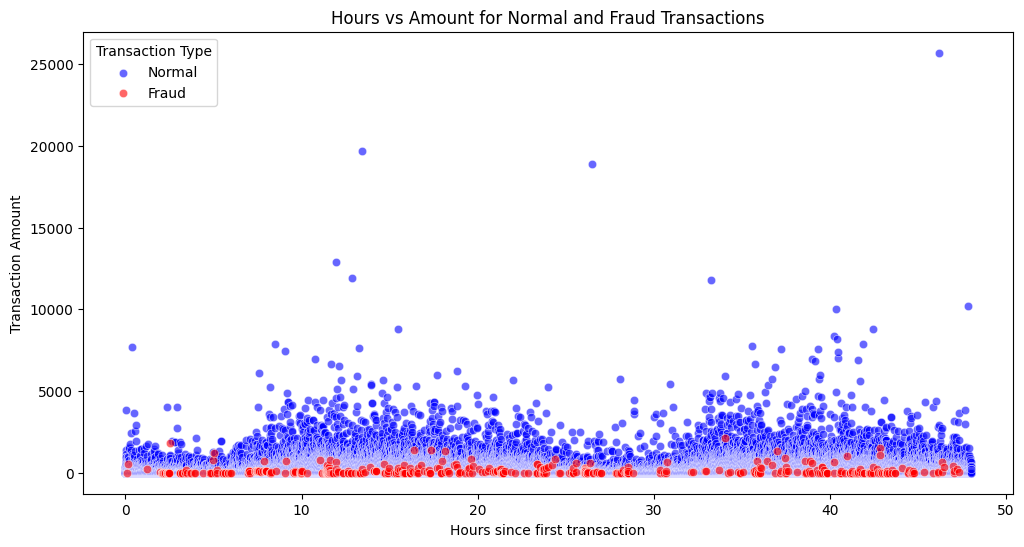

In [8]:
# Convert 'Time' from seconds to hours to make it more interpretable
data['Hours'] = data['Time'] / 3600

# Create a figure for plotting
plt.figure(figsize=(12, 6))

# Scatter plot of Time vs Amount for normal transactions
sns.scatterplot(x='Hours', y='Amount', data=data[data['Class'] == 0], color='blue', label='Normal', alpha=0.6)

# Scatter plot of Time vs Amount for fraud transactions
sns.scatterplot(x='Hours', y='Amount', data=data[data['Class'] == 1], color='red', label='Fraud', alpha=0.6)

plt.title('Hours vs Amount for Normal and Fraud Transactions')
plt.xlabel('Hours since first transaction')
plt.ylabel('Transaction Amount')
plt.legend(title='Transaction Type')
plt.show()

data = data.drop('Hours', axis=1)

The graph doesn't reveal much about the relationship between fraudulent transactions and the time they occurred. Therefore, we are dropping the 'Time' column.

# Data Preprocessing

In [ ]:
# Convert 'Time' and 'Amount' to log scale to compress dynamic range
# Adding 1 before taking the log to avoid log(0)

data['Log_Amount'] = np.log(data['Amount'] + 1)

# Drop the original 'Time' and 'Amount' columns
data.drop(['Time', 'Amount'], axis=1, inplace=True)

# Standardize the newly created log features
scaler = StandardScaler()
data[['Log_Amount']] = scaler.fit_transform(data[['Log_Amount']])


# Splitting the dataset into training and test sets
# Separating features (X) and target variable (y)
X = data.drop('Class', axis=1)
y = data['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Overview of the split
X_train.shape, X_test.shape

((227845, 29), (56962, 29))

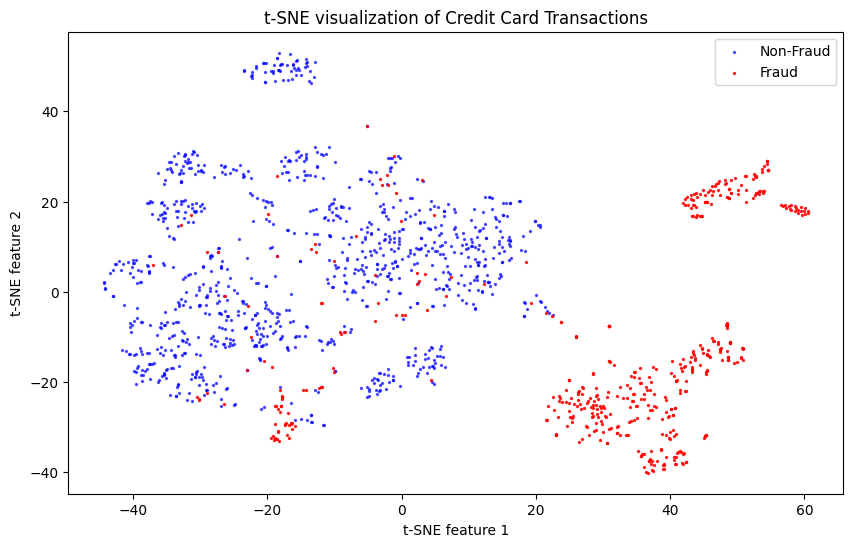

In [ ]:
# Sample for visualizations and model training
non_fraud = data[data['Class'] == 0].sample(1000, random_state=42)
fraud = data[data['Class'] == 1]
df = pd.concat([non_fraud, fraud]).sample(frac=1, random_state=42).reset_index(drop=True)
X = df.drop(['Class'], axis=1).values
Y = df['Class'].values


# Assuming tsne_plot is a function that you have defined to plot t-SNE visualization


### Utility Functions
def tsne_plot(X, Y, filename):
    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(X)
    plt.figure(figsize=(10, 6))
    plt.scatter(X_tsne[Y == 0, 0], X_tsne[Y == 0, 1], label='Non-Fraud', alpha=0.6, c='blue', s=2)
    plt.scatter(X_tsne[Y == 1, 0], X_tsne[Y == 1, 1], label='Fraud', alpha=0.8, c='red', s=2)
    plt.title('t-SNE visualization of Credit Card Transactions')
    plt.xlabel('t-SNE feature 1')
    plt.ylabel('t-SNE feature 2')
    plt.legend()
    plt.savefig(filename)
    plt.show()


tsne_plot(X, Y, "original.png")

In [ ]:
# Assuming y_test is a series with binary labels where 1 represents fraud and 0 represents non-fraud
num_fraud_cases = sum(y_test)
num_non_fraud_cases = len(y_test) - num_fraud_cases

# Filter the test set to include only the fraud cases
X_test_fraud = X_test[y_test == 1]

# Sample an equal number of non-fraud cases from the test set
X_test_non_fraud = X_test[y_test == 0].sample(n=num_fraud_cases, random_state=42)

# Combine the fraud and non-fraud cases to form the final test set
X_test_final = pd.concat([X_test_fraud, X_test_non_fraud])
y_test_final = pd.Series(np.where(X_test_final.index.isin(X_test_fraud.index), 1, 0), index=X_test_final.index)

# Verify the class distribution in the final test set
print("Class distribution in the final test set:")
print(y_test_final.value_counts())

# Optionally, shuffle the test set
# To shuffle the data correctly, use the sklearn shuffle utility
from sklearn.utils import shuffle
X_test_final, y_test_final = shuffle(X_test_final, y_test_final, random_state=42)

Class distribution in the final test set:
1    98
0    98
Name: count, dtype: int64


# AutoEncoder
## Architecher

In [ ]:
input_dim = X_train.shape[1]
encoding_dim = 14
input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [ ]:
autoencoder.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 29)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 14)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           105 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 7)              │            56 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 29)             │           232 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 813 (3.18 KB)

 Trainable params: 813 (3.18 KB)

 Non-trainable params: 0 (0.00 B)

## Training

In [ ]:
nb_epoch = 50
batch_size = 256
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="model.keras",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Epoch 1/50
891/891 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.2410 - loss: 1.1436 - val_accuracy: 0.5526 - val_loss: 0.9135
Epoch 2/50
891/891 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5678 - loss: 0.8721 - val_accuracy: 0.5784 - val_loss: 0.8578
Epoch 3/50
891/891 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5857 - loss: 0.8364 - val_accuracy: 0.5973 - val_loss: 0.8414
Epoch 4/50
891/891 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6003 - loss: 0.8548 - val_accuracy: 0.6025 - val_loss: 0.8342
Epoch 5/50
891/891 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6031 - loss: 0.8376 - val_accuracy: 0.6059 - val_loss: 0.8310
Epoch 6/50
891/891 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6024 - loss: 0.8271 - val_accuracy: 0.5960 - val_loss: 0.8296
Epoch 7/50
891/891 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6027 - loss: 0.8299 - val_accuracy: 0.5986 - val_loss: 0.8241
Epoch 8/50
891/891 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6070 - loss: 0.8171 - val_accuracy: 0.

In [ ]:
autoencoder = load_model('model.keras')

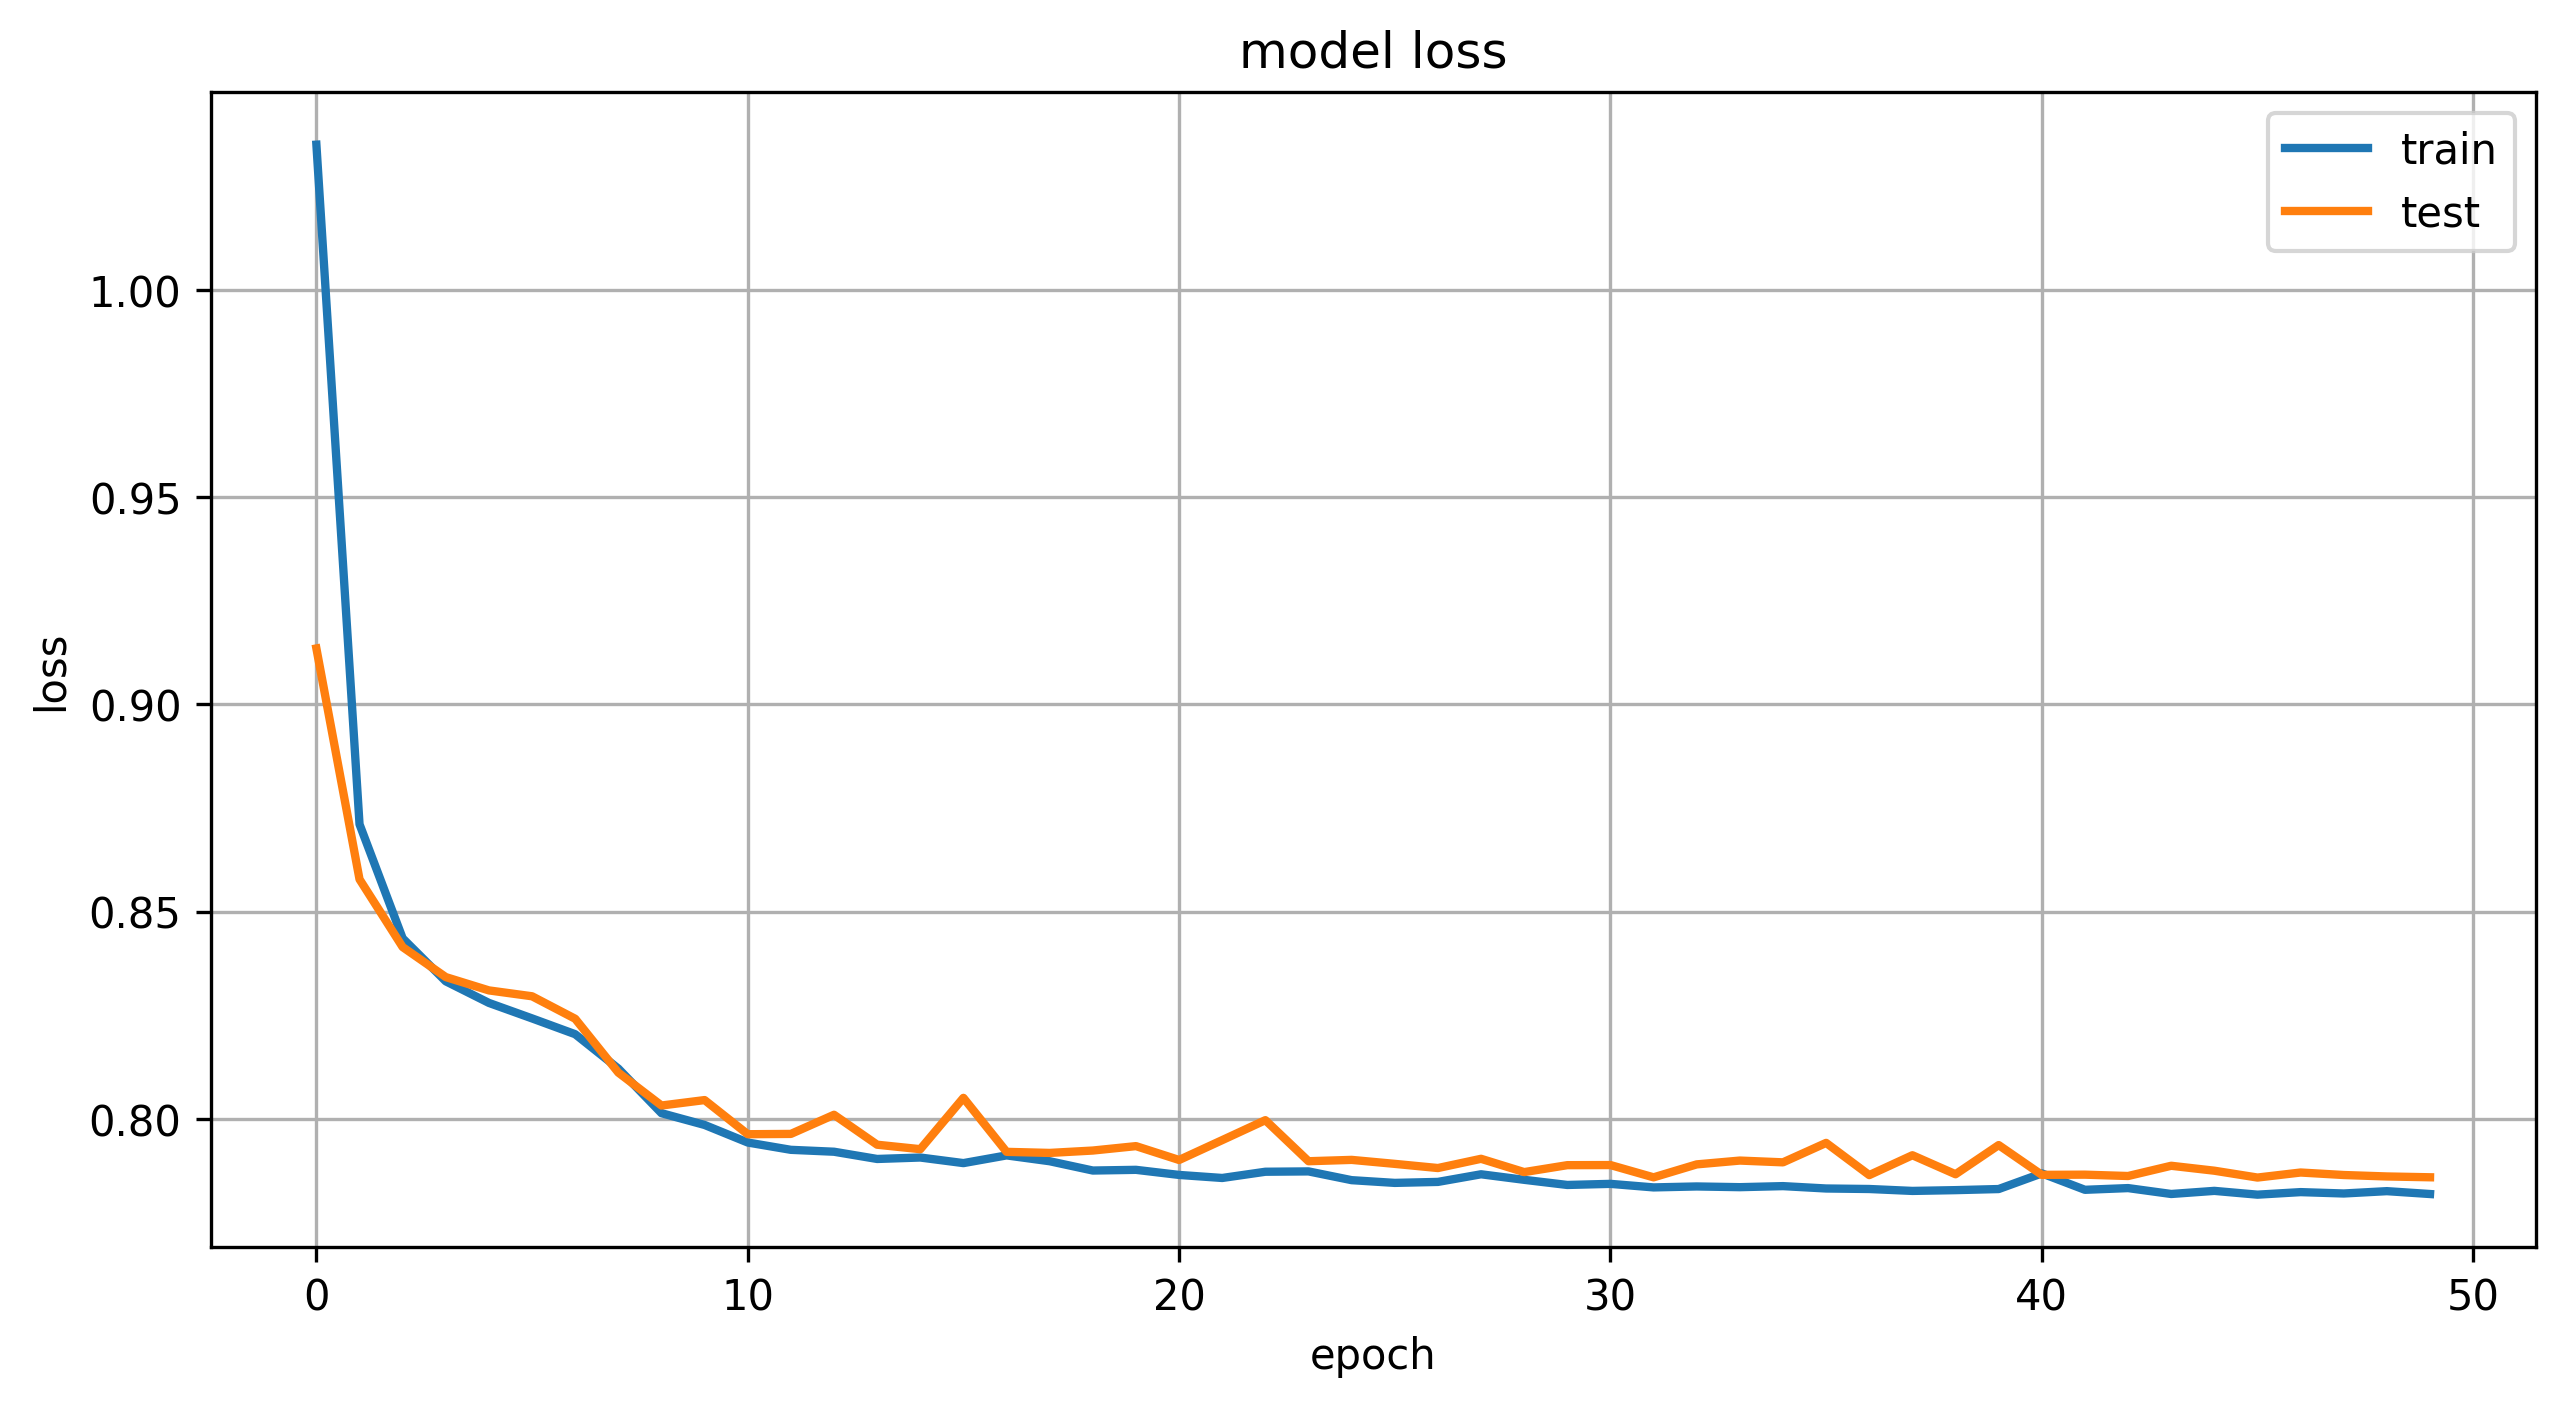

In [ ]:
plt.figure(figsize=(10, 5), dpi=300)  # Setting the figure size and dpi for high resolution
plt.plot(history['loss'], label='train', linewidth=2)
plt.plot(history['val_loss'], label='test', linewidth=2)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [ ]:
predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 1s 473us/step


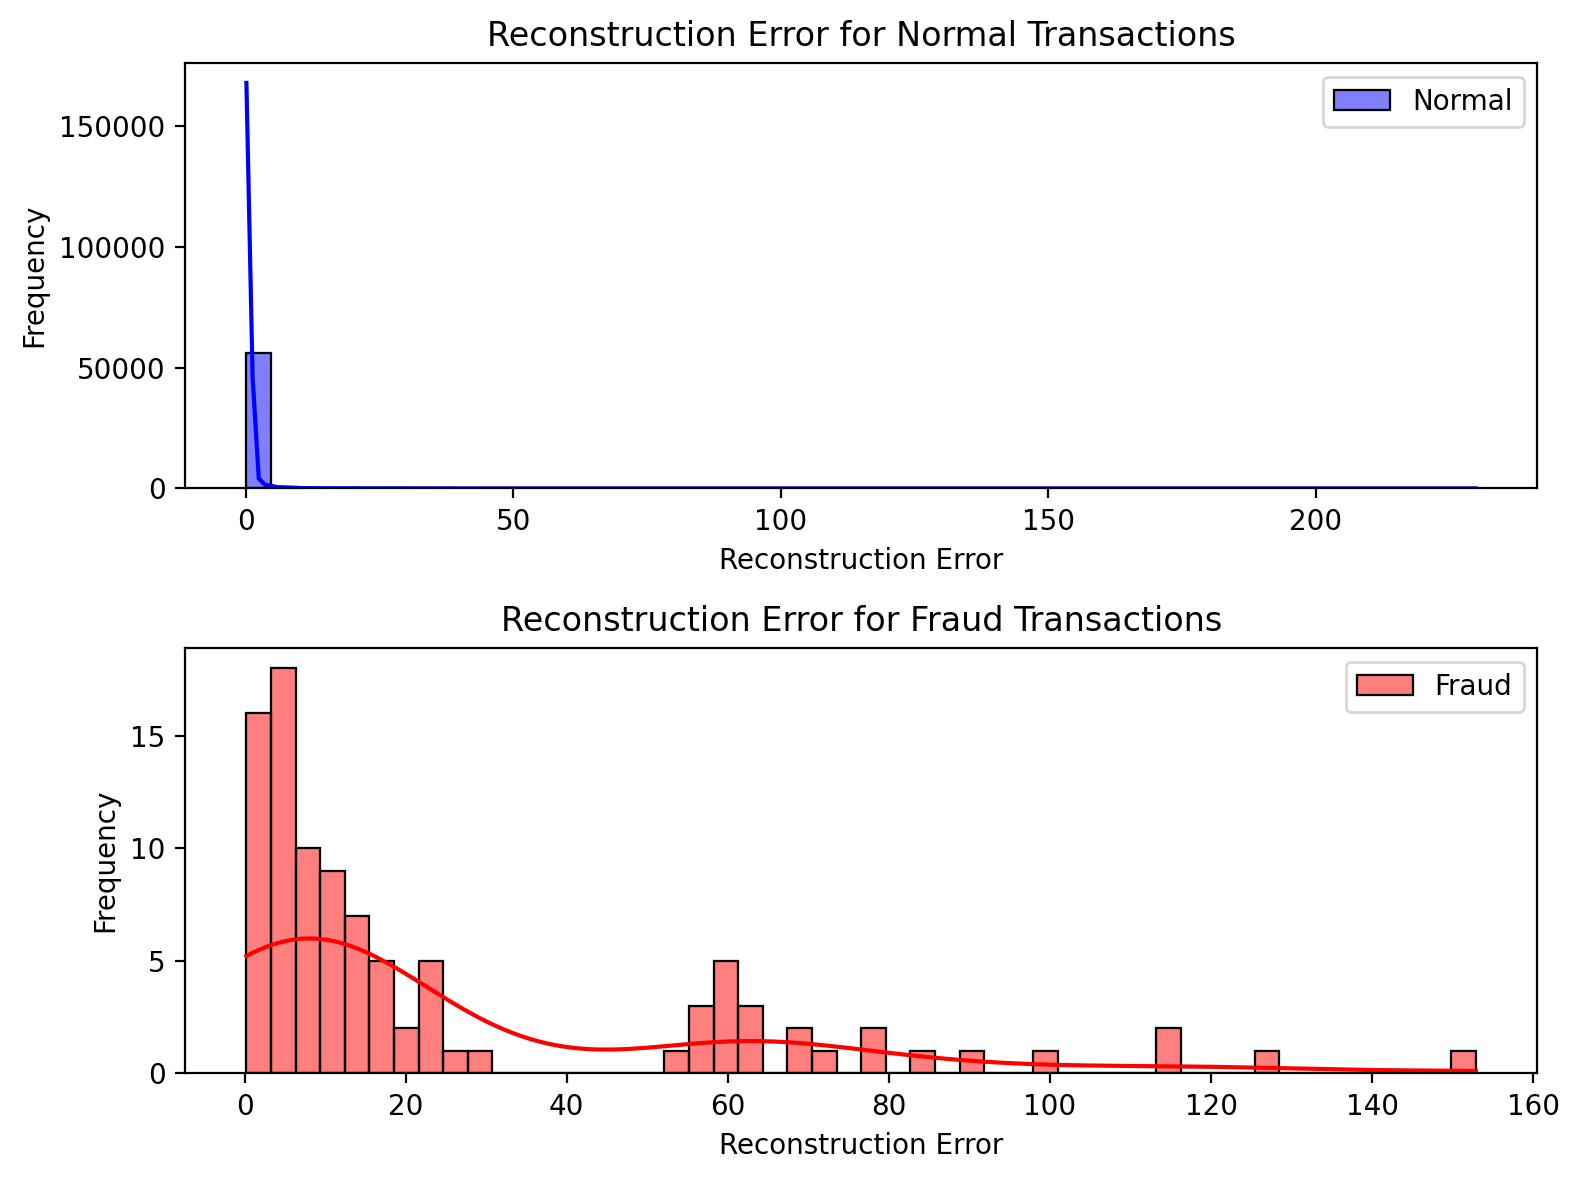

In [ ]:
# Separate the reconstruction error by class
mse_normal = mse[y_test == 0]
mse_fraud = mse[y_test == 1]

# Using the same mock data for demonstration purposes
# Normally you would replace 'mse_normal' and 'mse_fraud' with your actual data

# Create subplots
fig, ax = plt.subplots(2, 1, figsize=(8, 6), dpi=200)

# Histogram of reconstruction errors for normal transactions
sns.histplot(mse_normal, bins=50, kde=True, color='blue', label='Normal', ax=ax[0])
ax[0].set_title('Reconstruction Error for Normal Transactions')
ax[0].set_xlabel('Reconstruction Error')
ax[0].set_ylabel('Frequency')
ax[0].legend()

# Histogram of reconstruction errors for fraud transactions
sns.histplot(mse_fraud, bins=50, kde=True, color='red', label='Fraud', ax=ax[1])
ax[1].set_title('Reconstruction Error for Fraud Transactions')
ax[1].set_xlabel('Reconstruction Error')
ax[1].set_ylabel('Frequency')
ax[1].legend()

plt.tight_layout()
plt.show()

## Results

### ROC curve
The ROC curve below represents the performance of a classification model, with an
AUC (Area Under the Curve) of 0.9574, indicating a high level of accuracy. The true positive rate is
high across different thresholds, while maintaining a low false positive rate. This model is effective at
distinguishing between the classes (e.g., fraud and non-fraud).

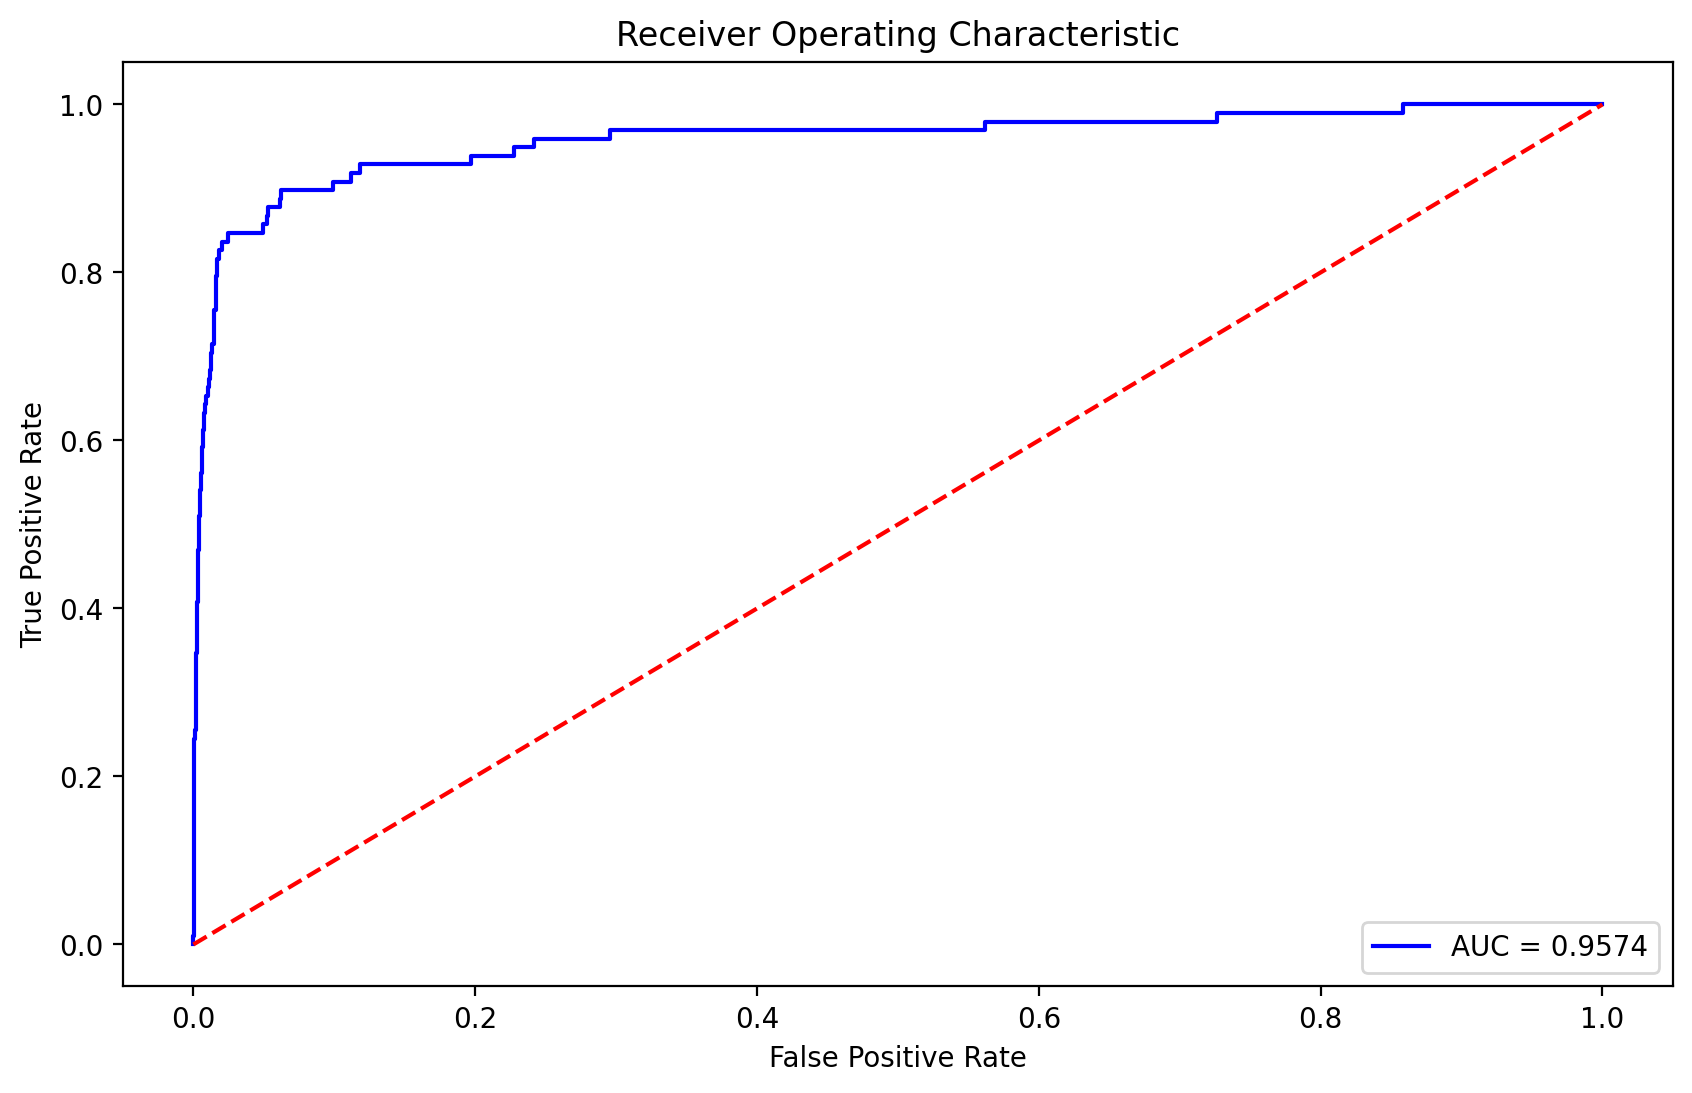

In [ ]:
# Compute ROC curve and ROC area for the test set
fpr, tpr, thresholds = roc_curve(y_test, mse)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6), dpi=200)
plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.title('Receiver Operating Characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [ ]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

### Recall vs Precision
The Precision-Recall curve below shows the trade-off between precision and
recall for a classification model at different thresholds. High precision near the y-axis suggests that the
model is accurate when it predicts positive classes, but recall drops quickly, indicating it doesn’t capture
all positive cases. The model is precise but not highly sensitive to all positives.

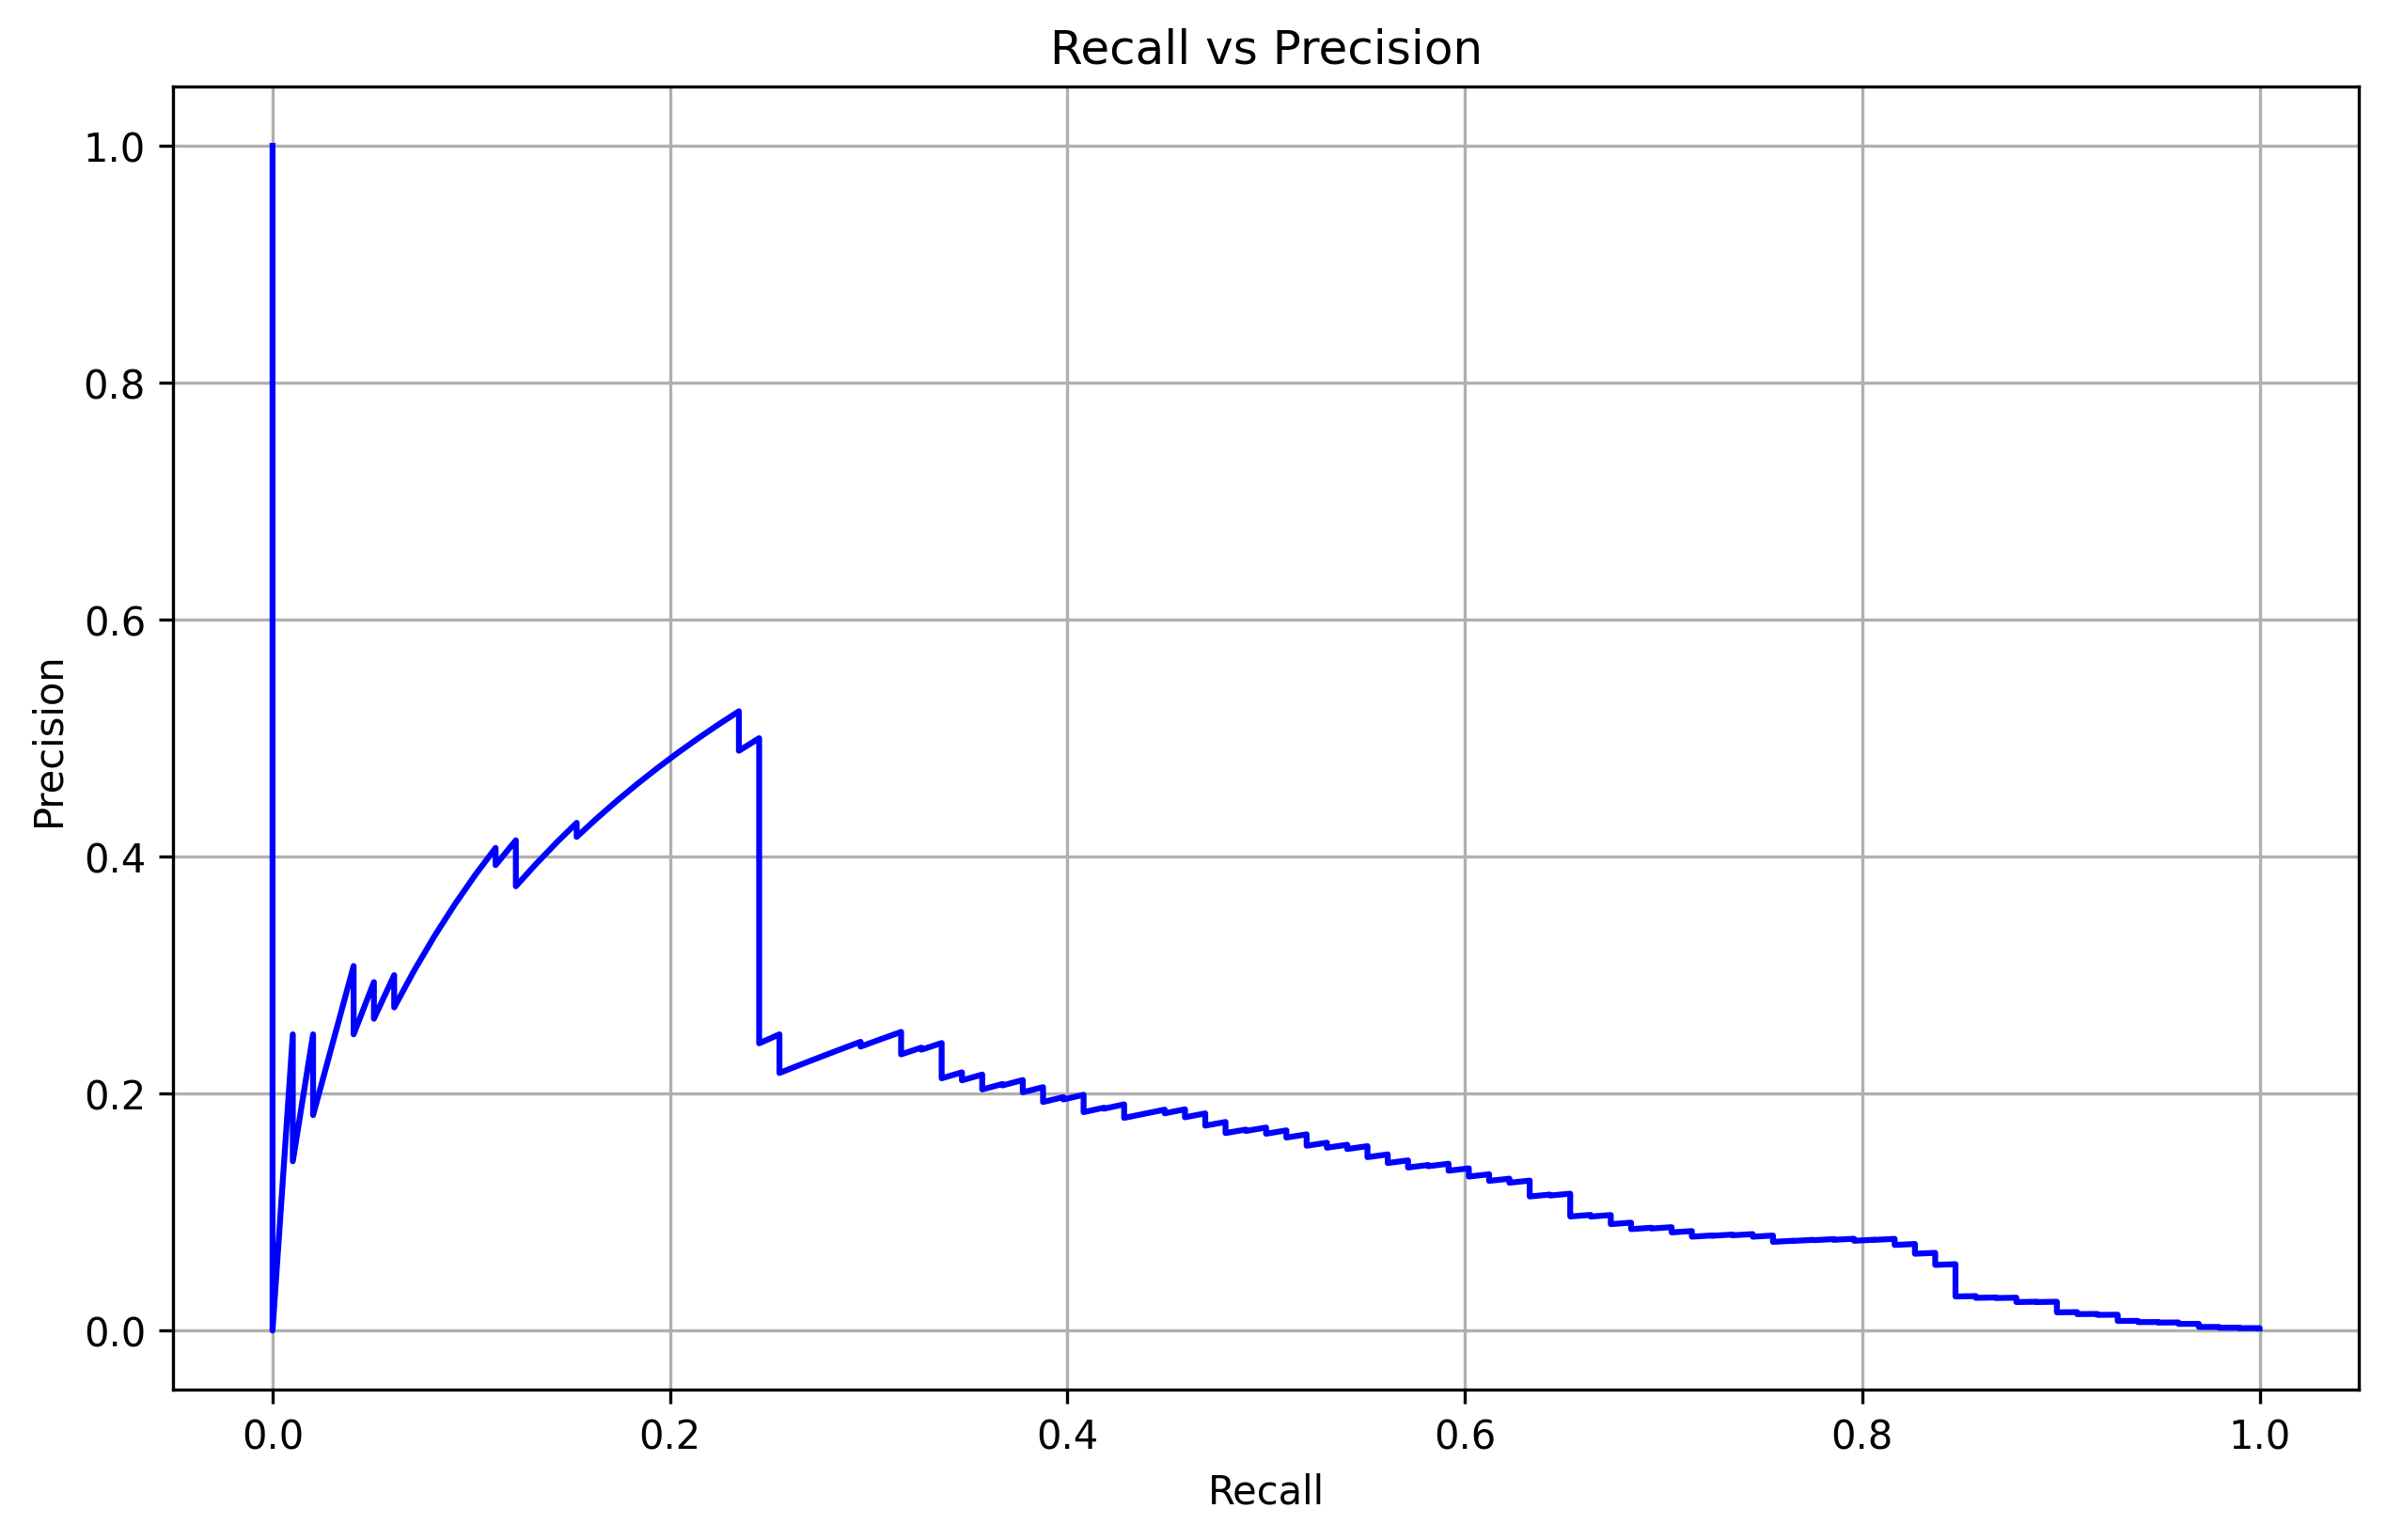

In [ ]:
precision, recall, th = precision_recall_curve(y_test, mse)
plt.figure(figsize=(10, 6), dpi=300)
plt.plot(recall, precision,  'b')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

### Precision for different threshold values
The graph shows how the precision of a predictive model
varies with different threshold values. As the threshold increases, precision fluctuates and tends to
decrease before shooting up to perfect precision at the highest threshold. This suggests that the model
becomes very selective, possibly only predicting positives when very sure, which may not be practical if
high recall is also desired.

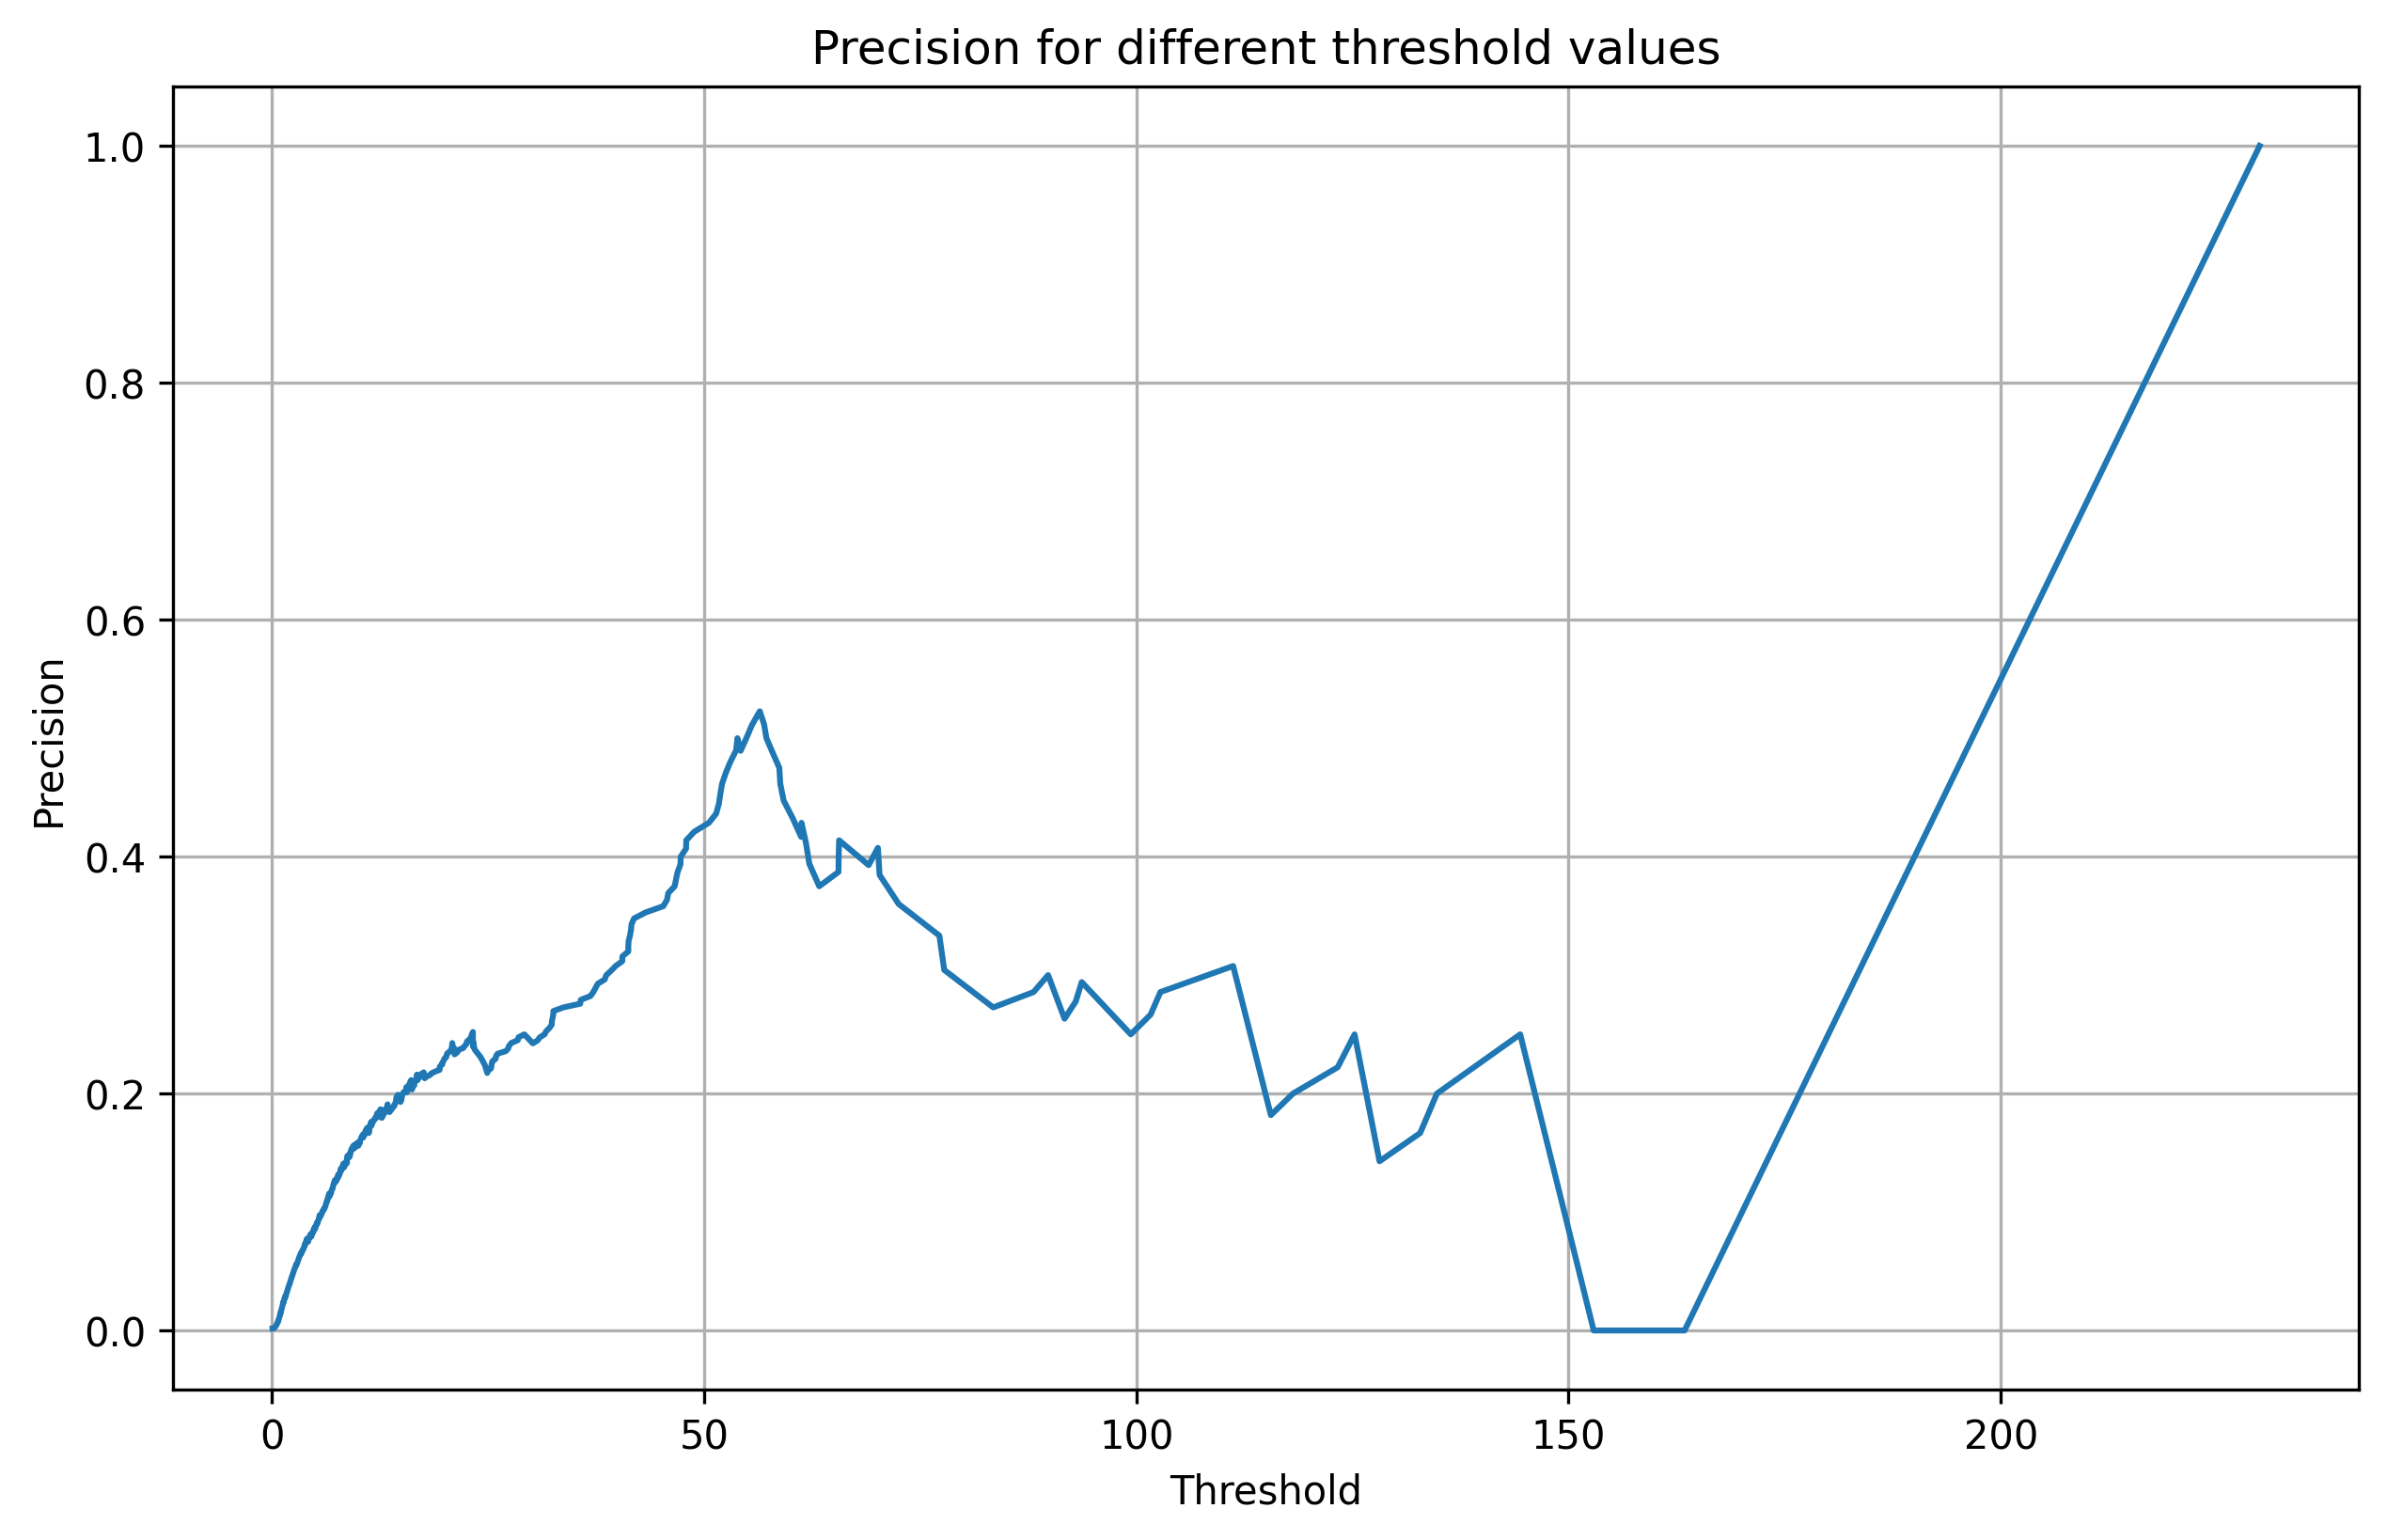

In [ ]:
plt.figure(figsize=(10, 6), dpi=300)
plt.plot(th, precision[1:])
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

### Threshold-Recall curve 
The graph illustrates recall as a function of varying reconstruction error
thresholds in a predictive model. Initially, recall is high, indicating most positive cases are captured, but
it declines sharply as the threshold increases, implying fewer positives are detected. At high threshold
levels, recall is low, suggesting many positive instances are missed by the model.

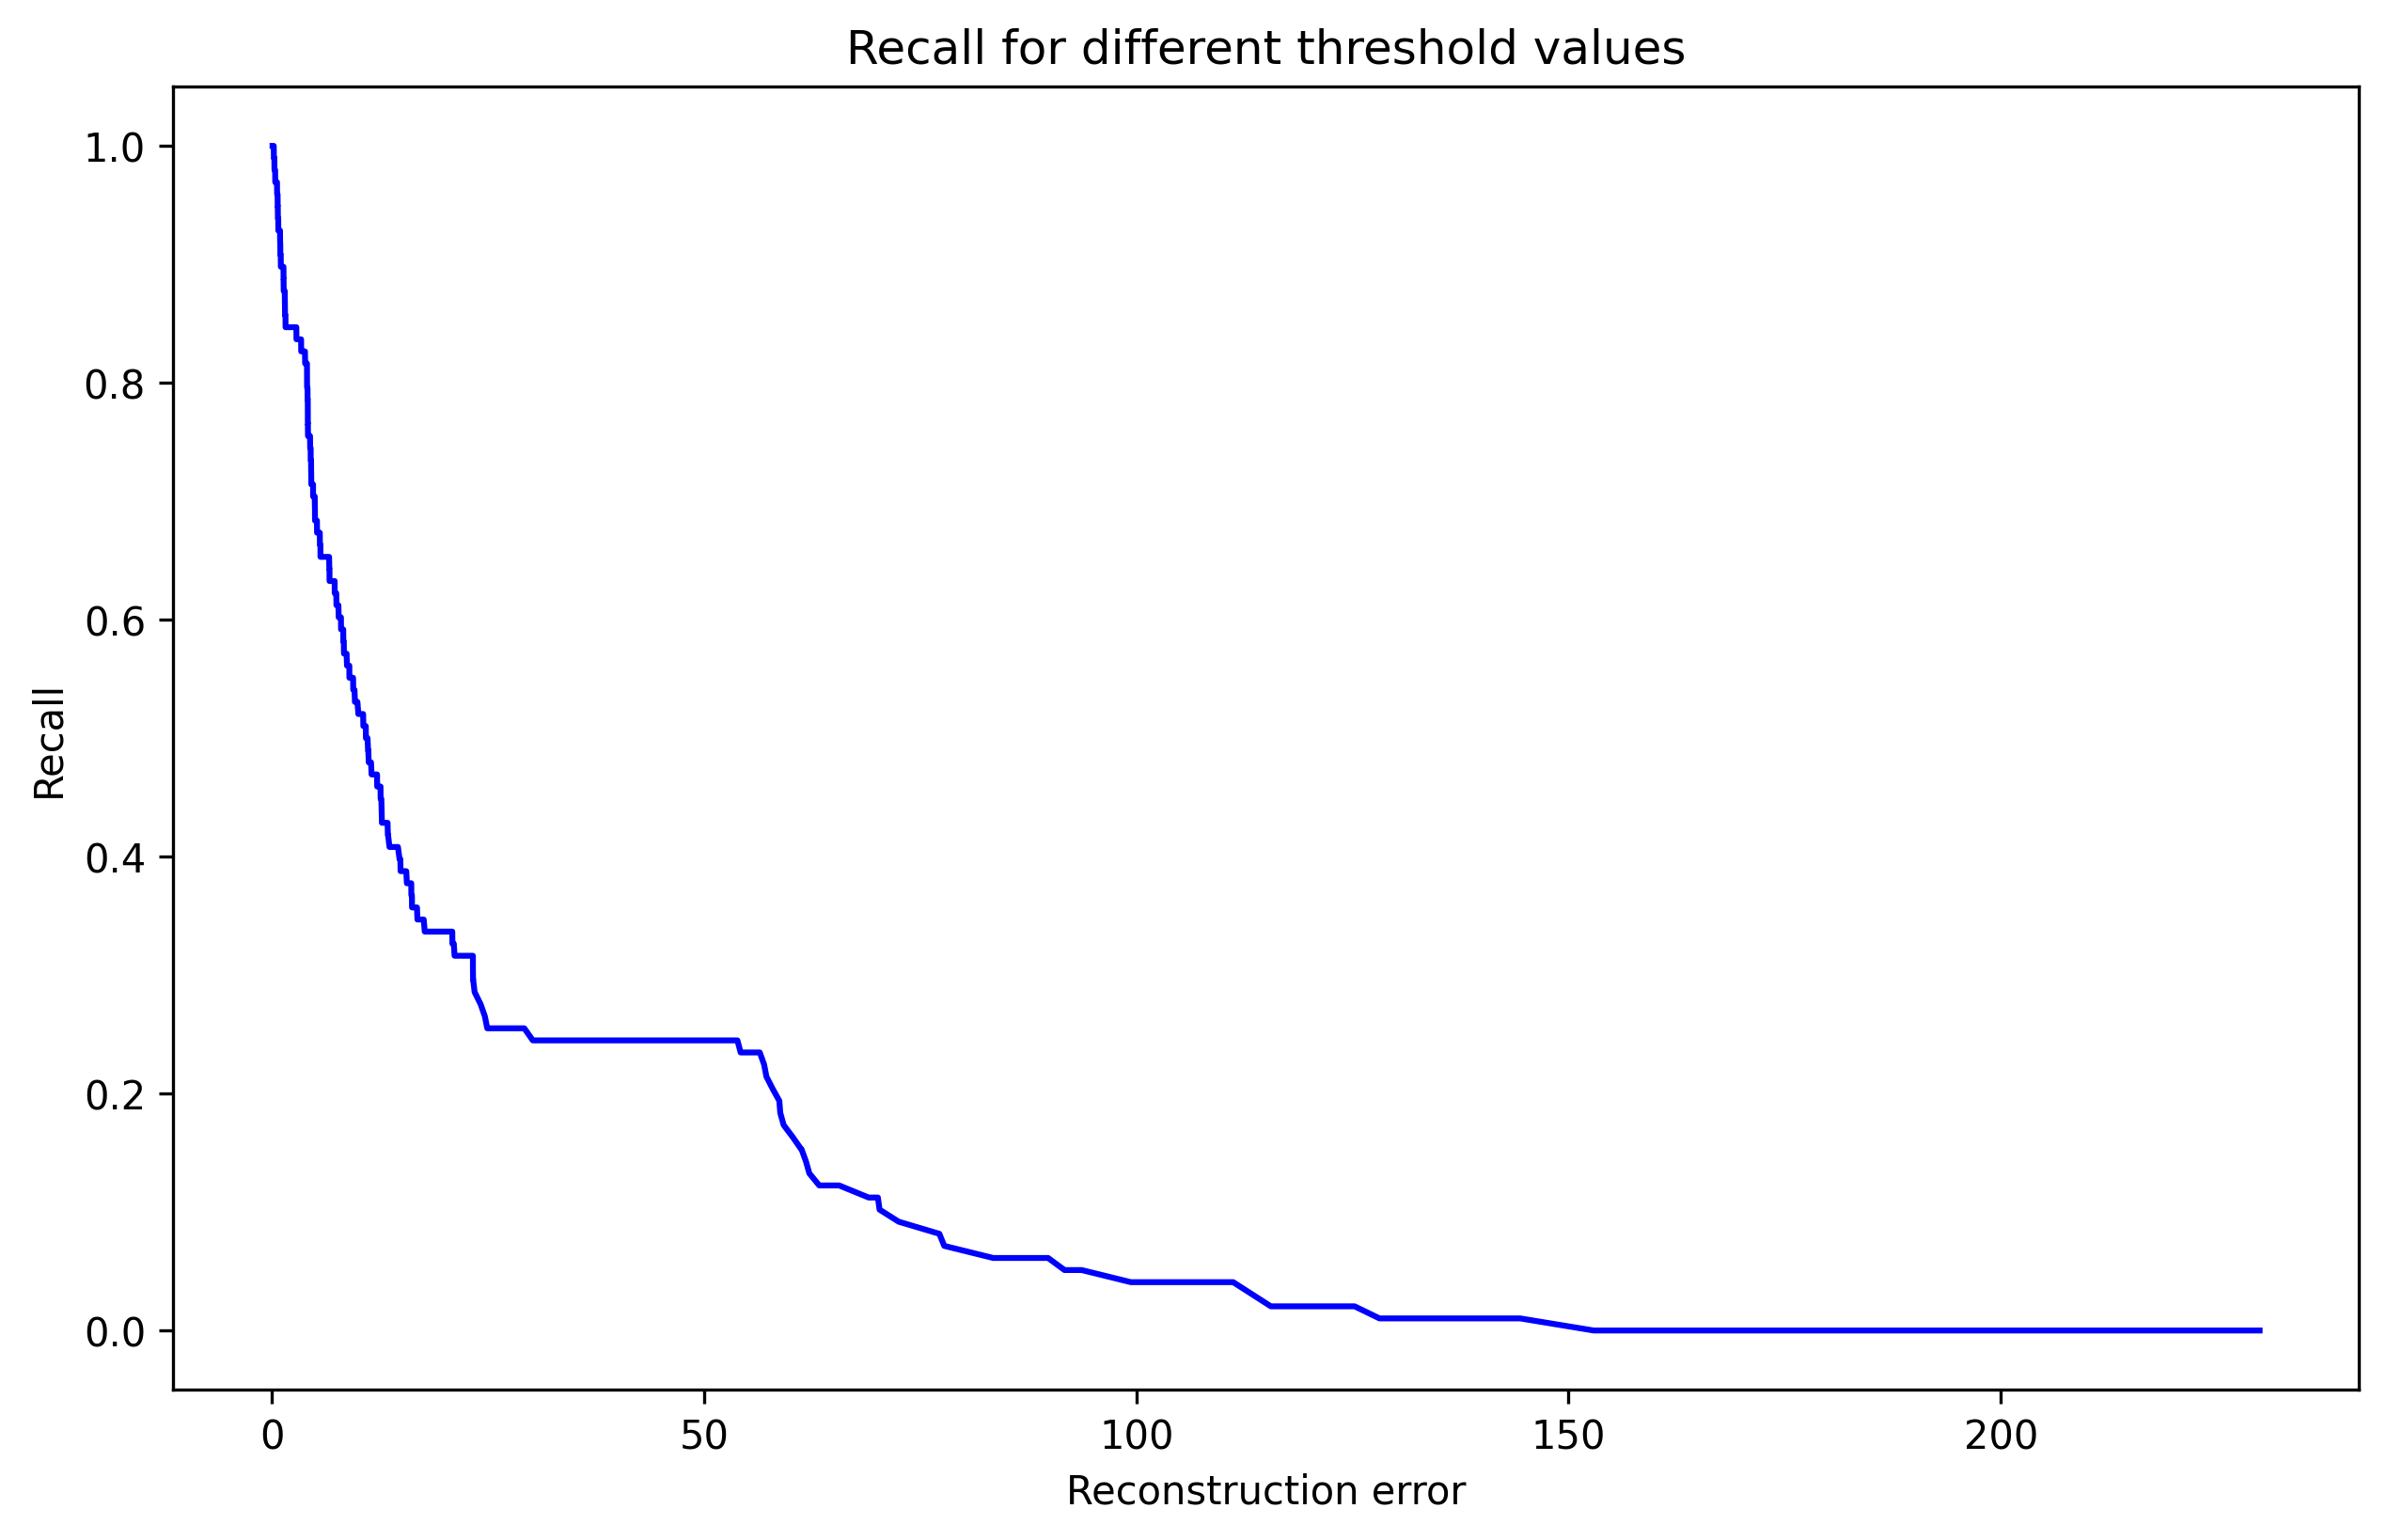

In [ ]:
plt.figure(figsize=(10, 6), dpi=300)
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

## F1 SCORE 
The calculation of the optimal threshold that maximizes the F1 score involves these concise mathematical steps:

1. **Precision and Recall Calculation**: 
   - Generate a set of predictions or error scores \(S\).
   - Use the function `precision_recall_curve(y, S)` to obtain precision (\(P\)) and recall (\(R\)) values at various thresholds (\(T\)) derived from \(S\).

2. **F1 Score Calculation for Each Threshold**:
   - For each threshold \(t\) in \(T\), calculate the F1 score:
     $$
     F1(t) = 2 \times \frac{P(t) \times R(t)}{P(t) + R(t)}
     $$
   - This formula ensures that the F1 score is computed for each possible threshold based on the corresponding precision and recall values.

3. **Optimal Threshold Determination**:
   - Identify the threshold \(t_{\text{opt}}\) that maximizes \(F1(t)\):
     $$
     t_{\text{opt}} = \text{argmax} \, F1(t)
     $$
   - Here, \(\text{argmax}\) is the operation that finds the argument (threshold) that results in the maximum F1 score.

4. **Using the Optimal Threshold**:
   - With \(t_{\text{opt}}\) known, classify future data points by comparing their score \(s\) against \(t_{\text{opt}}\).

This process effectively balances precision and recall, yielding the most reliable threshold for making binary decisions in various applications, particularly when handling skewed datasets.


In [ ]:


predictions = autoencoder.predict(X_test_final)

mse_final = np.mean(np.power(X_test_final - predictions, 2), axis=1)



precision, recall, thresholds = precision_recall_curve(y_test_final, mse_final)


# Calculate F1 scores for each possible threshold
f1_scores = 2 * (precision * recall) / (precision + recall)

# Find the index of the maximum F1 score
optimal_idx = np.nanargmax(f1_scores)


optimal_threshold = thresholds[optimal_idx]
optimal_f1 = f1_scores[optimal_idx]

print("Optimal Threshold:", optimal_threshold)
print("Maximum F1 Score:", optimal_f1)

# Convert reconstruction error to binary predictions
binary_predictions = [1 if error > optimal_threshold else 0 for error in mse_final]

# Calculate F1 score
final_f1_score = f1_score(y_test_final, binary_predictions)

print("F1 score:", final_f1_score)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
Optimal Threshold: 1.0259181923459462
Maximum F1 Score: 0.9175257731958762
F1 score: 0.9119170984455959


### Confusion matrix 
This confusion matrix shows that for a binary classification problem, the classifier
correctly identified 54,964 normal cases and 83 fraud cases. However, it incorrectly classified 1,900
normal cases as fraud (false positives) and failed to identify 15 fraud cases (false negatives). The matrix
suggests the model is relatively good at detecting normal cases but less effective at identifying fraud.

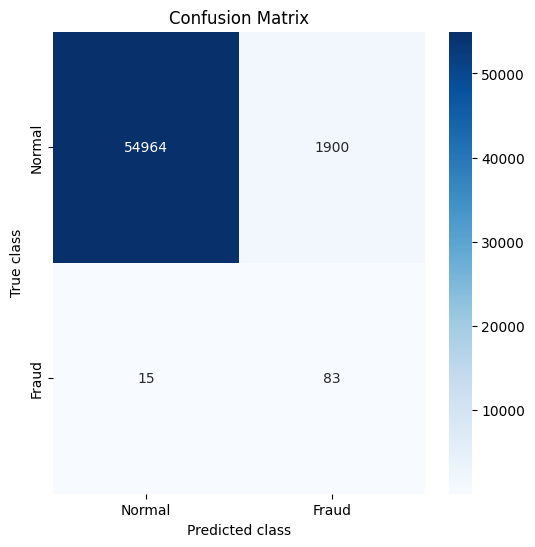

In [80]:
LABELS = ["Normal", "Fraud"]

# Confusion Matrix
prediction = [1 if e > optimal_threshold else 0 for e in mse]
conf_matrix = confusion_matrix(y_test, prediction)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt='d', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

# VAE


## Architecture
## Training

In [ ]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Define encoder model.
input_dim = X_train.shape[1]
latent_dim = 2

encoder_inputs = layers.Input(shape=(input_dim,))
x = layers.Dense(64, activation='relu')(encoder_inputs)  # Increased to 64 units
x = layers.Dense(128, activation='relu')(x)              # Added another layer with 128 units
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
z = Sampling()([z_mean, z_log_var])
encoder = models.Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')

# Increase the width and depth of the decoder as well.
latent_inputs = layers.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(128, activation='relu')(latent_inputs)  # Matched with encoder's second layer
x = layers.Dense(64, activation='relu')(x)               # Matched with encoder's first layer
decoder_outputs = layers.Dense(input_dim, activation='sigmoid')(x)
decoder = models.Model(latent_inputs, decoder_outputs, name='decoder')

# Define VAE model.
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        # Add KL divergence regularization loss.
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        kl_loss = K.mean(kl_loss)  # Ensure the KL loss is scalar.
        self.add_loss(kl_loss)
        return reconstructed
vae = VAE(encoder, decoder)
optimizer = Adam(learning_rate=1e-3)


# Compile VAE
vae = VAE(encoder, decoder)
optimizer = Adam(learning_rate=1e-3)

# Compile VAE
vae.compile(optimizer=optimizer, loss=MeanSquaredError())

# Prepare training and validation data.
X_train_np = X_train.to_numpy().astype(np.float32)
X_test_np = X_test.to_numpy().astype(np.float32)

# Ensure data is normalized if it's not already
X_train_np = X_train_np / np.max(X_train_np)
X_test_np = X_test_np / np.max(X_test_np)

# Training loop.
batch_size = 1000
epochs = 50  # Increase the number of epochs

# Add callbacks for early stopping and learning rate reduction
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
]

# Fit the model using data.
history = vae.fit(
    X_train_np, X_train_np,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test_np, X_test_np),
    callbacks=callbacks
)


Epoch 1/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0969 - val_loss: 7.3677e-04 - learning_rate: 0.0010
Epoch 2/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.8328e-04 - val_loss: 6.0824e-04 - learning_rate: 0.0010
Epoch 3/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0208e-04 - val_loss: 5.8690e-04 - learning_rate: 0.0010
Epoch 4/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8.7061e-05 - val_loss: 5.7919e-04 - learning_rate: 0.0010
Epoch 5/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8.2661e-05 - val_loss: 5.7548e-04 - learning_rate: 0.0010
Epoch 6/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8.0003e-05 - val_loss: 5.7337e-04 - learning_rate: 0.0010
Epoch 7/50
226/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.8065e-05
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.8063e-05 - val_loss: 5.7226e-04 - learning_rate: 0.0010
Epoch 8/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s

In [ ]:
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 29)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 64)        │      1,920 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 128)       │      8,320 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │        258 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │        258 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 2)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 10,756 (42.02 KB)

 Trainable params: 10,756 (42.02 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ z_sampling (InputLayer)         │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 29)             │         1,885 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,525 (41.11 KB)

 Trainable params: 10,525 (41.11 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
vae.summary()

Model: "vae_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Functional)            │ ?                      │        10,756 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ ?                      │        10,525 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,845 (249.40 KB)

 Trainable params: 21,281 (83.13 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 42,564 (166.27 KB)

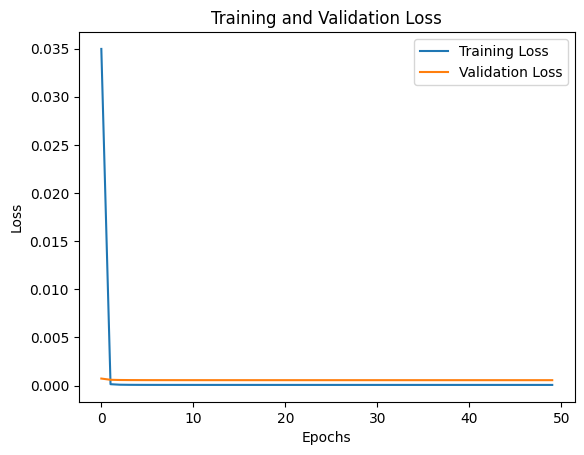

In [ ]:
# Plotting training loss
plt.plot(history.history['loss'], label='Training Loss')
# Plotting validation loss
plt.plot(history.history['val_loss'], label='Validation Loss')

# Adding title and labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Display the plot
plt.show()


In [ ]:
def reconstruction_log_prob(eval_samples, reconstruct_samples_n):
    # Get z_mean and z_log_var from the encoder
    z_mean, z_log_var, _ = encoder(eval_samples)
    
    # Prepare to sample from the latent space
    epsilon = tf.random.normal(shape=(reconstruct_samples_n, z_mean.shape[0], z_mean.shape[1]))
    z_samples = z_mean[tf.newaxis, :, :] + tf.exp(0.5 * z_log_var[tf.newaxis, :, :]) * epsilon  # Broadcasted sample
    
    # Decode each sample
    decoded_samples = tf.map_fn(decoder, z_samples, dtype=tf.float32)  # Assumes decoder can be called like this
    
    # Assuming the output of decoder is the reconstruction itself, we use a suitable log_prob measure:
    # Here we manually compute MSE as a proxy for log_prob under a Gaussian assumption
    mse = tf.reduce_mean(tf.square(decoded_samples - eval_samples[tf.newaxis, :, :]), axis=[-1])
    log_prob = -mse  # Negate MSE to simulate log probability (higher is better)

    return tf.reduce_mean(log_prob, axis=0)  # Average over all samples


## Results

### Latent space mean
This scatter plot represents data points in a two-dimensional latent space, with
each point colored according to its class. The dense cluster of purple points near the center suggests a
concentration of one class, while the sparser yellow points indicate another class. The plot could be
showing how a model like a Variational Autoencoder separates features of different classes in its learned
latent space

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


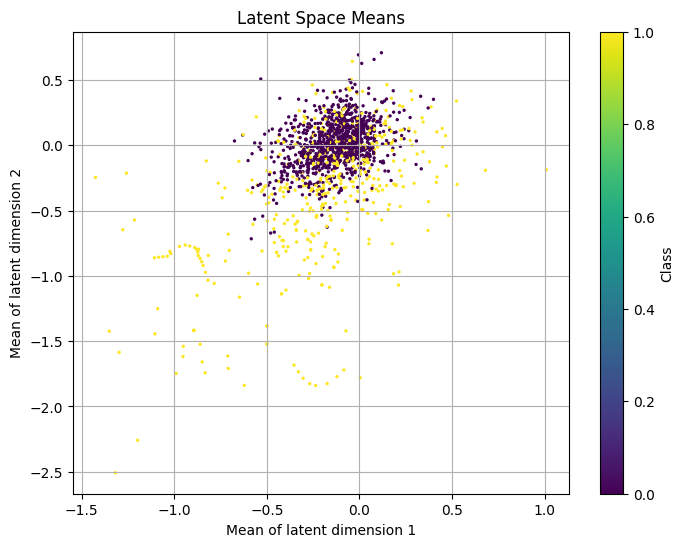

In [ ]:
# Use the encoder to get the mean, log variance, and sampled z outputs
z_mean, z_log_var, _ = encoder.predict(X)  # Use the predict method and capture all three outputs

# Plot these means colored by their corresponding label `Y`
plt.figure(figsize=(8, 6))
scatter = plt.scatter(z_mean[:, 0], z_mean[:, 1], c=Y, cmap='viridis', s=2)
plt.colorbar(scatter, label='Class')
plt.title('Latent Space Means')
plt.xlabel('Mean of latent dimension 1')
plt.ylabel('Mean of latent dimension 2')
plt.grid(True)
plt.show()


### Latent space standard deviation
The scatter plot illustrates data points in terms of their standard
deviation across two latent dimensions, colored by class. A cluster of purple points indicates a class
with lower variability, while yellow points dispersed throughout indicate higher variability in another
class. This visualization can be useful for understanding the spread and overlap of the different classes
in a model’s latent space

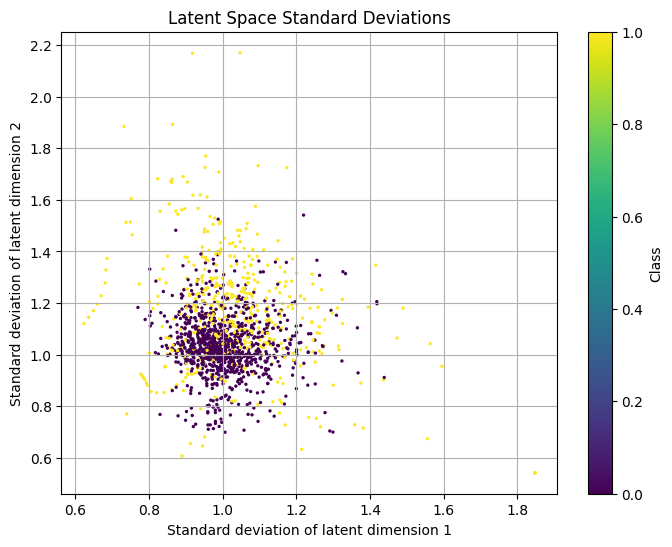

In [ ]:
latent_x_std = tf.exp(0.5 * z_log_var)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(latent_x_std[:, 0], latent_x_std[:, 1], c=Y, cmap='viridis', s=2)
plt.colorbar(scatter, label='Class')
plt.title('Latent Space Standard Deviations')
plt.xlabel('Standard deviation of latent dimension 1')
plt.ylabel('Standard deviation of latent dimension 2')
plt.grid(True)
plt.show()

### Reconstruction log probability 
The histogram compares the log probability of reconstruction for
non-fraud and fraud transactions. Non-fraud transactions show a high frequency of high log probability
scores, indicating the model reconstructs them with high likelihood. Fraud transactions, however, have
a lower frequency and are spread out across lower log probability values, suggesting they are less likely
to be reconstructed accurately by the model

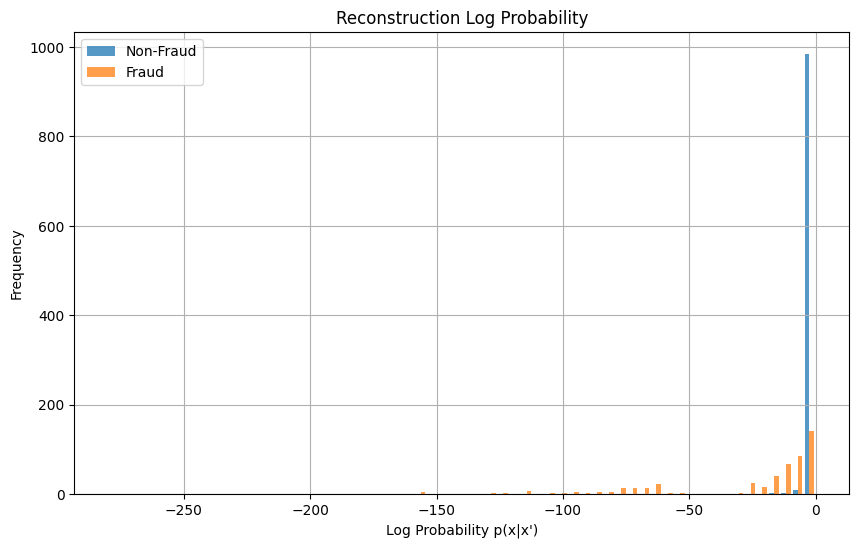

In [ ]:
# Compute log probabilities
reconstruct_samples_n = 50  # Example: 100 samples
x_log_prob = reconstruction_log_prob(X, reconstruct_samples_n)

# Create a histogram of log probabilities for both classes
plt.figure(figsize=(10, 6))
plt.hist([x_log_prob[Y == 0], x_log_prob[Y == 1]], bins=60, label=['Non-Fraud', 'Fraud'], alpha=0.75)
plt.title('Reconstruction Log Probability')
plt.xlabel("Log Probability p(x|x')")
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
LABELS = ["Normal", "Fraud"]
# Predict the reconstruction loss on the test set
test_predictions = vae.predict(X_test)
mse = np.mean(np.power(X_test - test_predictions, 2), axis=1)

# Create a DataFrame with true class labels and the calculated MSE
error_df = pd.DataFrame({'reconstruction_error': mse,
                         'true_class': y_test})

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


### Reconstruction Error for Fraud Transactions
Normal transactions are tightly clustered around a
low reconstruction error, indicating accurate model predictions. Fraud transactions are less frequent
and have a wider distribution of reconstruction errors, likely due to their anomalous nature which the
model finds harder to reconstruct accurately

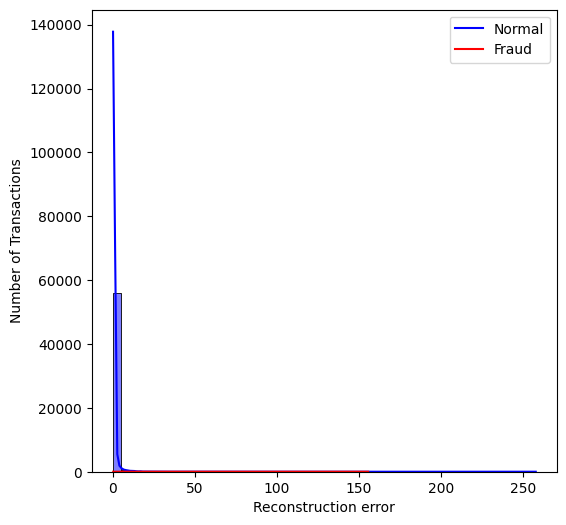

In [ ]:
# Visualizing the Reconstruction Error for different classes
fig, ax = plt.subplots(figsize=(6, 6))
normal_error_df = error_df[(error_df['true_class'] == 0)]
fraud_error_df = error_df[error_df['true_class'] == 1]

sns.histplot(normal_error_df['reconstruction_error'], bins=50, kde=True, color='blue', ax=ax)
sns.histplot(fraud_error_df['reconstruction_error'], bins=50, kde=True, color='red', ax=ax)
plt.xlabel('Reconstruction error')
plt.ylabel('Number of Transactions')
plt.legend(['Normal', 'Fraud'])
plt.show()

### Recall vs Precision
The graph shows precision and recall values for various thresholds in a classification
model. Precision starts high but quickly drops and fluctuates as the threshold increases, while recall
decreases more steadily. The dashed line may represent an optimal threshold where a balance between
precision and recall is achieved, often used to optimize a model’s performance on both metrics.


3.8


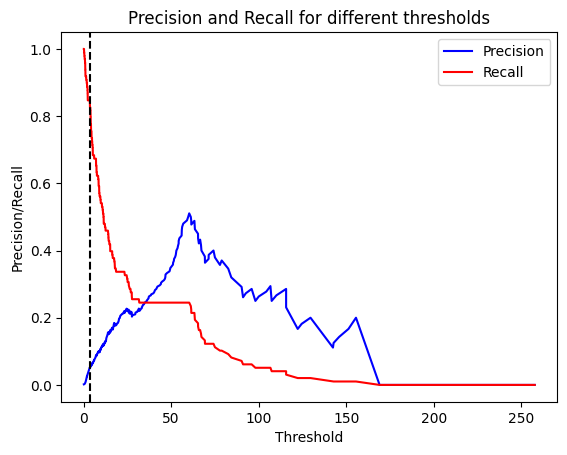

In [ ]:
# Determine the optimal threshold
precision, recall, threshold = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
#threshold_f1 = threshold[np.argmax(2 * recall[:-1] * precision[:-1] / (recall[:-1] + precision[:-1]))]  # F1 threshold

threshold_f1 = 3.8

print(threshold_f1)

plt.plot(threshold, precision[:-1], 'b', label='Precision')
plt.plot(threshold, recall[:-1], 'r', label='Recall')
plt.axvline(x=threshold_f1, color='k', linestyle='--')
plt.title('Precision and Recall for different thresholds')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

### ROC curve
The ROC curve depicts the performance of a Variational Autoencoder (VAE) with an
AUC of 0.953, which is quite high, indicating strong discriminative power. The curve stays close to the
top-left corner, suggesting a high true positive rate with a low false positive rate, which is desirable in
many classification tasks.


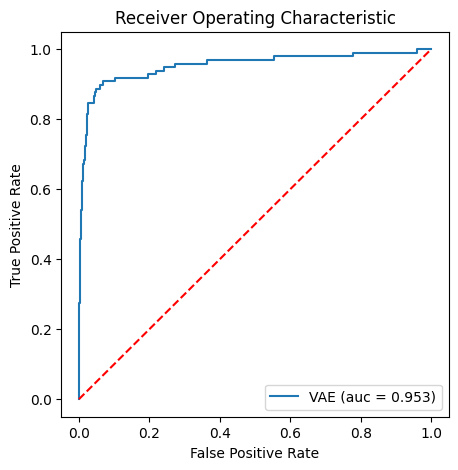

In [ ]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5, 5), dpi=100)
plt.plot(fpr, tpr, linestyle='-', label='VAE (auc = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend()
plt.show()

### Confusion matrix
The confusion matrix shows a classifier’s predictions, with 55,451 true negatives
and 81 true positives, indicating correct classifications for normal and fraud cases respectively. However,
there are 1,413 false positives and 17 false negatives, showing instances where the model incorrectly
classified normal transactions as fraud and missed identifying some fraud transactions

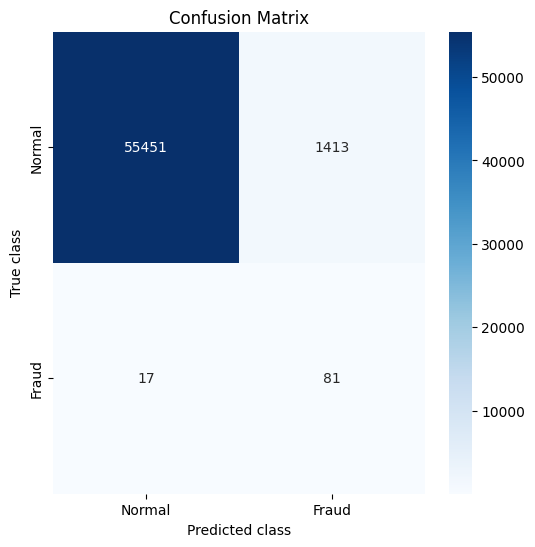

In [ ]:
# Confusion Matrix
prediction = [1 if e > threshold_f1 else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, prediction)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt='d', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [ ]:
reconstructed = vae.predict(X_test_np)
reconstruction_error = np.mean(np.square(X_test_np - reconstructed), axis=1)

# Calculate optimal threshold and F1 score using reconstruction error
def calculate_optimal_f1(y_true, errors):
    precision, recall, thresholds = precision_recall_curve(y_true, errors)
    f1_scores = 2 * (precision * recall) / (precision + recall)
    f1_scores = np.nan_to_num(f1_scores)  # Handle potential NaNs
    max_index = np.argmax(f1_scores)
    return f1_scores[max_index], thresholds[max_index]


1781/1781 ━━━━━━━━━━━━━━━━━━━━ 1s 548us/step


In [ ]:
# Function to balance the dataset
def balance_classes(X, y):
    # Separate the classes
    class_0 = X[y == 0]
    class_1 = X[y == 1]

    # Find the smaller class size
    n_samples = min(len(class_0), len(class_1))

    # Resample classes to the size of the smaller class
    class_0_downsampled = resample(class_0, replace=False, n_samples=n_samples, random_state=42)
    class_1_downsampled = resample(class_1, replace=False, n_samples=n_samples, random_state=42)

    # Concatenate back to a single array
    X_balanced = np.vstack((class_0_downsampled, class_1_downsampled))
    y_balanced = np.array([0] * n_samples + [1] * n_samples)

    return X_balanced, y_balanced

# Balancing the classes in the test set
X_test_balanced, y_test_balanced = balance_classes(X_test_np, y_test)

# Prediction using the VAE
reconstructed_balanced = vae.predict(X_test_balanced)
reconstruction_error_balanced = np.mean(np.square(X_test_balanced - reconstructed_balanced), axis=1)

# Calculate optimal threshold and F1 score using balanced reconstruction error
optimal_f1, optimal_threshold = calculate_optimal_f1(y_test_balanced, reconstruction_error_balanced)
print("Optimal Threshold:", optimal_threshold)
print("Optimal F1 Score:", optimal_f1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step
Optimal Threshold: 0.0007648746
Optimal F1 Score: 0.923076923076923
